Dropdown(description='Select Model:', options=('Decision Tree Classifier', 'Random Forest Classifier', 'Suppor…

Output()

Button(description='Submit', style=ButtonStyle())

Output()

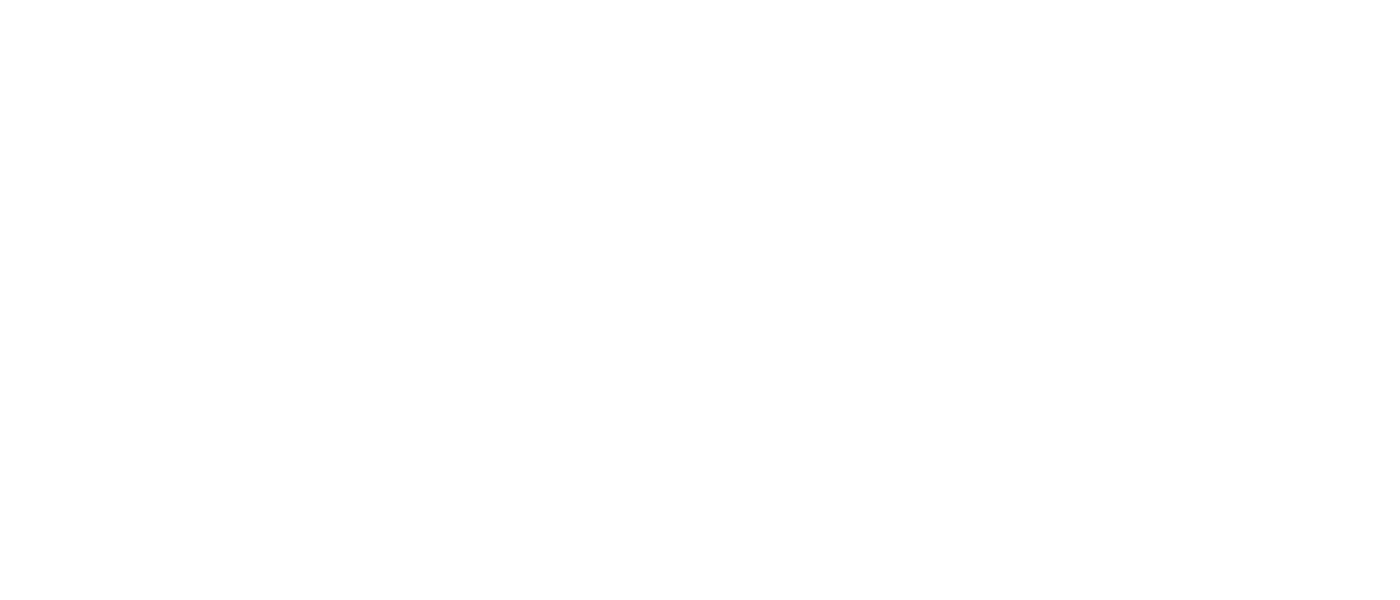

In [1]:
%matplotlib widget
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sys.path.append('../src/visualization')
from playground import playground
playground()
